### Import the Data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gauravduttakiit/resume-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gauravduttakiit/resume-dataset/versions/1


In [49]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import re

In [3]:
file_path = '/root/.cache/kagglehub/datasets/gauravduttakiit/resume-dataset/versions/1/UpdatedResumeDataSet.csv'
df = pd.read_csv(file_path)
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


### Explore the Data

In [4]:
print(df.shape)
print(df.info())
print(df.describe(include='all'))

(962, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB
None
              Category                                             Resume
count              962                                                962
unique              25                                                166
top     Java Developer  Technical Skills Web Technologies: Angular JS,...
freq                84                                                 18


Here we can see that there are 962 rows and 2 columns in our data. All of the are object and there is no null value among them. We have 25 unique value in `Category` that we should check them and there are 166 unique values in `Resume` wich menas, it is possible to have duplicates.

In [5]:
df.rename({'Category':'job_title', 'Resume':'resume_text'}, inplace=True, axis=1)

We change the name of the columns for readability and make our dataset better.

In [6]:
df['job_title'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

This is the unique jobs we have in `job_title`.

In [7]:
new_df = df.drop_duplicates(subset=['resume_text'], keep='first')

Here we remove the duplicates based on their value in `resume_text` column and we kept the first one for each duplicate.

In [8]:
df['resume_length'] = df['resume_text'].apply(lambda x: len(x.split()))
print(df['resume_length'].describe())

count     962.000000
mean      450.497921
std       415.868459
min        19.000000
25%       166.000000
50%       329.000000
75%       589.250000
max      2209.000000
Name: resume_length, dtype: float64


Hee we learn the length of each resume, the longest resume has 2209 words and the shortest one has 19 words, which we can see as an invalid resume.

In [9]:
df['job_title'].value_counts()

,count
job_title,
Java Developer,84
Testing,70
DevOps Engineer,55
Python Developer,48
Web Designing,45
HR,44
Hadoop,42
Blockchain,40
ETL Developer,40


### Text Prerpocessing

In [10]:
df['cleaned_text'] = df['resume_text'].apply(lambda x: x.lower())

In here we turned all the words in the `cleaned_text` into lower case.

In [11]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x:(re.sub('[^a-zA-Z\s]',' ',x)))

In here we removed anything that is not among lower, upper case of a-z and whitespace.

#### Tokenization

In [12]:
df['tokenized_text'] = df['cleaned_text'].apply(lambda x: word_tokenize(x))

#### Remove the StopWords

In [13]:
stop_words = set(stopwords.words('english'))
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [word for word in x if word not in stop_words])

####  Lemmatization

In [14]:
lemmatizer = WordNetLemmatizer()
df['lemmatized_text'] = df['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

#### Combined Tokens Back into Text

In [16]:
df['final_text'] = df['lemmatized_text'].apply(lambda x: ' '.join(x))

### Verify Preprocessing

In [17]:
df[['resume_text', 'cleaned_text', 'final_text']].head()

,resume_text,cleaned_text,final_text
0,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas...,skill programming language python panda numpy ...
1,Education Details \r\nMay 2013 to May 2017 B.E...,education details \r\nmay to may b e...,education detail may may b e uit rgpv data sci...
2,"Areas of Interest Deep Learning, Control Syste...",areas of interest deep learning control syste...,area interest deep learning control system des...
3,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills r python sap hana table...,skill r python sap hana tableau sap hana sql s...
4,"Education Details \r\n MCA YMCAUST, Faridab...",education details \r\n mca ymcaust faridab...,education detail mca ymcaust faridabad haryana...


### Feature Extraction

In [31]:
vectorizer = TfidfVectorizer(max_features=1000)

In [32]:
tfidf_matrix = vectorizer.fit_transform(df['final_text'])

In [33]:
print(tfidf_matrix)
print(tfidf_matrix.shape)

  (0, 837)	0.023851565281425607
  (0, 709)	0.03199291076592898
  (0, 494)	0.07774274326806158
  (0, 729)	0.1927614584006728
  (0, 611)	0.04845911692034919
  (0, 504)	0.12262335937953454
  (0, 851)	0.02583447633724782
  (0, 475)	0.02691560062864468
  (0, 476)	0.13577135702152376
  (0, 481)	0.14866505191098286
  (0, 528)	0.03726951715210976
  (0, 506)	0.07217164819170331
  (0, 752)	0.04389163456686583
  (0, 222)	0.08473424312801892
  (0, 901)	0.04144930091561703
  (0, 141)	0.04563999573445149
  (0, 29)	0.22407042875431116
  (0, 987)	0.2395840718565586
  (0, 699)	0.07909600075622349
  (0, 603)	0.03929953758619073
  (0, 214)	0.02270557714651803
  (0, 593)	0.02921242416220704
  (0, 395)	0.05369890820450736
  (0, 218)	0.1043159143604933
  (0, 890)	0.15988381700412088
  :	:
  (961, 393)	0.03853234418538811
  (961, 574)	0.058731021723045986
  (961, 416)	0.04605309037571194
  (961, 998)	0.2357088456081503
  (961, 60)	0.12891849437197056
  (961, 37)	0.06334431261292171
  (961, 662)	0.03749263279

In [34]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Inspect the top words for a sample resume
resume_index = 0
top_words = tfidf_df.iloc[resume_index].sort_values(ascending=False).head(10)
print("Top words in Resume {}:\n".format(resume_index), top_words)


Top words in Resume 0:
 review         0.301534
analytics      0.252320
data           0.240352
word           0.239584
analysis       0.224070
information    0.214286
python         0.192761
tool           0.189813
text           0.178549
tableau        0.159884
Name: 0, dtype: float64


#### Convert TF-IDF Matrix to a DataFrame

In [35]:
feature_names = vectorizer.get_feature_names_out()

tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_matrix.head()

,ability,acceptance,access,according,account,accounting,achieve,achieved,achievement,achieving,...,workflow,working,workshop,world,writing,wrote,www,xml,xp,year
0,0.0,0.0,0.0,0.0,0.0,0.050166,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020841
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.115939,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.317655
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.037809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.302855
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061505
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470627


#### Inspect the Features

In [36]:
# Example: Display the top 10 words with the highest TF-IDF scores in the first resume
top_words = tfidf_matrix.iloc[0].sort_values(ascending=False).head(10)
print("Top words in the first resume:\n", top_words)


Top words in the first resume:
 review         0.301534
analytics      0.252320
data           0.240352
word           0.239584
analysis       0.224070
information    0.214286
python         0.192761
tool           0.189813
text           0.178549
tableau        0.159884
Name: 0, dtype: float64


### Clustering the Resumes

In [37]:
num_clusters = 5
kmeans = KMeans(n_clusters = num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
df['cluster'] = kmeans.labels_

In [38]:
df['cluster'].value_counts()

,count
cluster,
3,351
1,205
4,182
2,124
0,100


In [39]:
for cluster in range(num_clusters):
  print(f'Cluster {cluster} sample:\n', df[df['cluster'] == cluster]['final_text'].head(3))

Cluster 0 sample:
 50    software skill general computer proficiency pr...
61    software skill general computer proficiency pr...
72    software skill general computer proficiency pr...
Name: final_text, dtype: object
Cluster 1 sample:
 1    education detail may may b e uit rgpv data sci...
2    area interest deep learning control system des...
4    education detail mca ymcaust faridabad haryana...
Name: final_text, dtype: object
Cluster 2 sample:
 8     personal skill ability quickly grasp technical...
18    personal skill ability quickly grasp technical...
28    personal skill ability quickly grasp technical...
Name: final_text, dtype: object
Cluster 3 sample:
 0    skill programming language python panda numpy ...
3    skill r python sap hana tableau sap hana sql s...
9    expertise data quantitative analysis decision ...
Name: final_text, dtype: object
Cluster 4 sample:
 5     skill c basic iot python matlab data science m...
15    skill c basic iot python matlab data science m...

### Visualize the Clusters

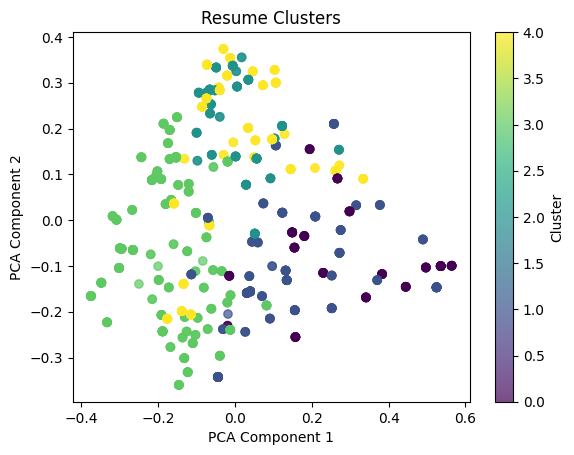

In [43]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix)

# Plot the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.title('Resume Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

### Analyze Words and Skills in Each Cluster

In [44]:
for cluster in range(df['cluster'].nunique()):  # Loop through each cluster
    print(f"Cluster {cluster} contains {len(df[df['cluster'] == cluster])} resumes.")

Cluster 0 contains 100 resumes.
Cluster 1 contains 205 resumes.
Cluster 2 contains 124 resumes.
Cluster 3 contains 351 resumes.
Cluster 4 contains 182 resumes.


In [45]:
# Add the cluster labels to the TF-IDF matrix
tfidf_df['cluster'] = df['cluster']

# Group by cluster and compute the average TF-IDF score for each word
cluster_keywords = tfidf_df.groupby('cluster').mean()

# Display top words for each cluster
for cluster in cluster_keywords.index:
    print(f"Top words for Cluster {cluster}:\n")
    print(cluster_keywords.loc[cluster].sort_values(ascending=False).head(10))
    print("\n")


Top words for Cluster 0:

java          0.335763
exprience     0.143144
developer     0.131699
month         0.131628
jsp           0.093779
ajax          0.089279
technology    0.088334
spring        0.088179
detail        0.087361
android       0.083397
Name: 0, dtype: float64


Top words for Cluster 1:

exprience      0.140922
month          0.140713
python         0.111817
less           0.103662
project        0.097886
year           0.085987
pune           0.064980
web            0.062895
application    0.061996
cs             0.060828
Name: 1, dtype: float64


Top words for Cluster 2:

january        0.151277
detail         0.100836
art            0.099926
maharashtra    0.092814
mumbai         0.092677
company        0.089353
fitness        0.080855
blockchain     0.073312
civil          0.071004
university     0.068790
Name: 2, dtype: float64


Top words for Cluster 3:

project       0.078254
sale          0.066137
test          0.061764
data          0.061698
management    0.

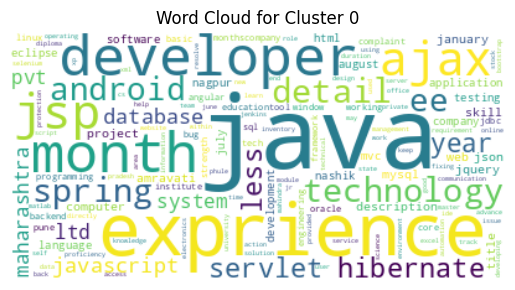

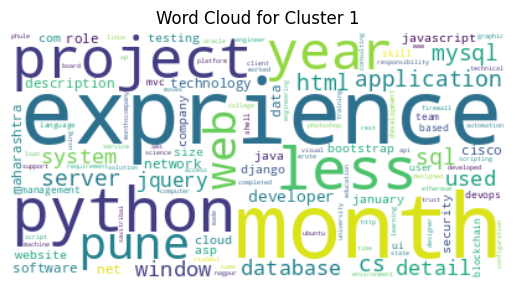

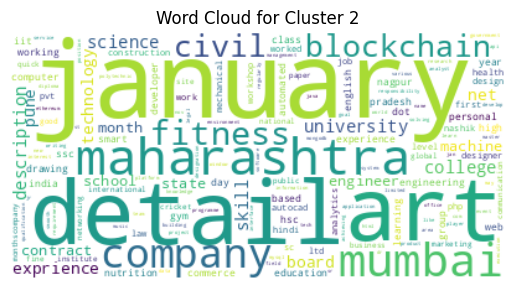

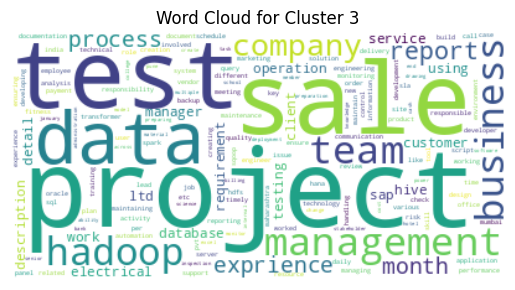

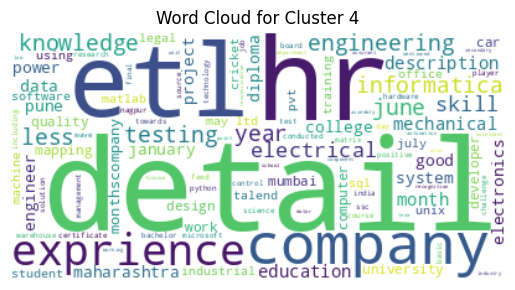

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud for each cluster
for cluster in cluster_keywords.index:
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(
        cluster_keywords.loc[cluster].sort_values(ascending=False).to_dict()
    )
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster}")
    plt.show()


### Assign Scores

In [47]:
def calculate_score(resume_text, cluster_top_words):
    """
    Calculate a score for a resume based on its match with the top words in its cluster.
    """
    # Split the resume into words
    words = set(resume_text.split())

    # Count the number of matching words with the cluster's top words
    score = sum(1 for word in cluster_top_words if word in words)

    return score

In [48]:
# Get the top words for each cluster
top_words_per_cluster = {}
for cluster in cluster_keywords.index:
    top_words_per_cluster[cluster] = cluster_keywords.loc[cluster].sort_values(ascending=False).head(10).index.tolist()

# Calculate scores for each resume
df['score'] = df.apply(
    lambda row: calculate_score(row['final_text'], top_words_per_cluster[row['cluster']]),
    axis=1
)

In [50]:
# Normalize scores to the range 0–10
scaler = MinMaxScaler(feature_range=(0, 10))
df['final_score'] = scaler.fit_transform(df[['score']])

# Preview the results
print(df[['final_text', 'cluster', 'score', 'final_score']].head())

                                          final_text  cluster  score  \
0  skill programming language python panda numpy ...        3      5   
1  education detail may may b e uit rgpv data sci...        1      5   
2  area interest deep learning control system des...        1      6   
3  skill r python sap hana tableau sap hana sql s...        3      8   
4  education detail mca ymcaust faridabad haryana...        1      5   

   final_score  
0         5.00  
1         5.00  
2         6.25  
3         8.75  
4         5.00  


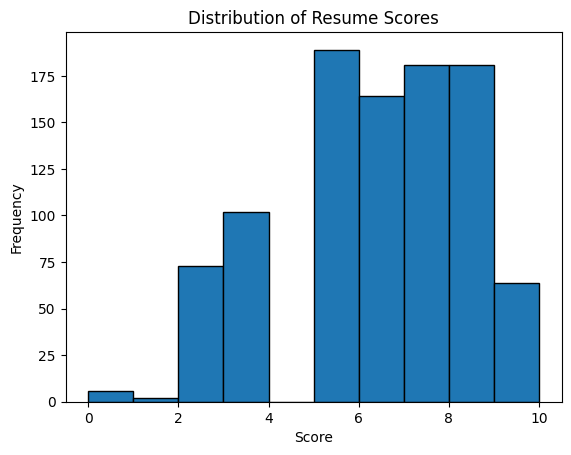

In [51]:
import matplotlib.pyplot as plt

plt.hist(df['final_score'], bins=10, edgecolor='black')
plt.title('Distribution of Resume Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


### Validate the Results

# **Resume Parser and Clustering Project**

## **Project Goal**
To automate resume parsing, clustering, and scoring using AI techniques:
- Group resumes by similar words and skills into clusters.
- Assign a score to each resume (0 to 10) based on its relevance to a specific domain or cluster.

---

## **Steps Taken**

### 1. **Preprocessing**
- Removed noise from resume text:
  - Stopwords removed.
  - Text lemmatized and tokenized.
- Created a clean, standardized text format for analysis.

---

### 2. **Feature Extraction**
- **TF-IDF Vectorizer** was used to convert the cleaned resumes into numerical features.
- Each resume is represented as a vector of word importance.

---

### 3. **Clustering**
- Applied **K-means clustering** to group resumes into 5 distinct clusters:
  - Each cluster represents a set of resumes with similar themes.
- Visualized clusters using **PCA** (Principal Component Analysis) to reduce dimensions and plot in 2D.

---

### 4. **Scoring Resumes**
- Calculated scores for each resume based on its match with the top words from its cluster.
- Normalized scores to a range of 0–10 for consistency.

---

## **Cluster Analysis**

### **Cluster 0: Java Development**
- **Top Words:** `java`, `developer`, `jsp`, `technology`, `spring`
- **Theme:** Focused on Java developers and related technologies.

### **Cluster 1: Web and Python Development**
- **Top Words:** `python`, `project`, `web`, `application`, `cs`
- **Theme:** Resumes focusing on Python, web development, and general programming.

### **Cluster 2: General/Creative/Regional**
- **Top Words:** `january`, `art`, `fitness`, `blockchain`, `civil`
- **Theme:** Mixed cluster, with references to creative or blockchain-related fields and regional data.

### **Cluster 3: Data Roles**
- **Top Words:** `project`, `data`, `hadoop`, `management`, `business`
- **Theme:** Data-related roles, including data analysis, engineering, and business management.

### **Cluster 4: HR and ETL**
- **Top Words:** `hr`, `etl`, `engineering`, `informatica`, `knowledge`
- **Theme:** Focused on HR-related roles and engineering data workflows.

---

## **Score Analysis**

### **Histogram of Resume Scores**
- Most resumes score between **5 and 8**, indicating moderate alignment with their clusters.
- Few outliers:
  - **High Scores (>8):** Resumes highly relevant to their clusters (e.g., Cluster 0, Cluster 3).
  - **Low Scores (<2):** Resumes that do not align well with any cluster.

### **Example Scores:**
| Resume ID | Cluster | Score | Final Score |
|-----------|---------|-------|-------------|
| 0         | 3       | 5     | 5.00        |
| 1         | 1       | 5     | 5.00        |
| 2         | 1       | 6     | 6.25        |
| 3         | 3       | 8     | 8.75        |
| 4         | 1       | 5     | 5.00        |

---

## **Visualizations**

### **Histogram of Scores**
![Score Distribution](link_to_your_image_if_uploaded)

### **Word Clouds for Clusters**
- **Cluster 0: Java Development**
  - ![Cluster 0](link_to_cluster_0_wordcloud)
- **Cluster 1: Web and Python Development**
  - ![Cluster 1](link_to_cluster_1_wordcloud)
- **Cluster 3: Data Roles**
  - ![Cluster 3](link_to_cluster_3_wordcloud)
- **Cluster 4: HR and ETL**
  - ![Cluster 4](link_to_cluster_4_wordcloud)

---

## **Key Insights**
1. **Distinct Clusters:**
   - Most clusters (e.g., Java Development, Data Roles) have clear themes.
   - Cluster 2 is more mixed, requiring further refinement.

2. **Scores Reflect Relevance:**
   - Higher scores align with resumes that match their clusters strongly.
   - Scoring provides a quantitative way to rank resumes.

---

## **Limitations and Future Improvements**
1. **Mixed Cluster Refinement:**
   - Cluster 2 contains varied themes. Preprocessing or clustering adjustments can improve grouping.
2. **Enhanced Scoring:**
   - Introduce domain-specific weights to prioritize certain keywords.
3. **Contextual Understanding:**
   - Use word embeddings (e.g., Word2Vec, GloVe) to better capture relationships between similar words.

---

## **Conclusion**
This project demonstrates an end-to-end pipeline for parsing, clustering, and scoring resumes using AI techniques. It automates the process of analyzing large volumes of resumes, helping recruiters quickly identify top candidates.

